<a href="https://colab.research.google.com/github/nicoleolivetto/CNN/blob/main/covid_data_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [26]:
covid_ds =pd.read_csv("covid_ds.csv")
covid_ds

,Unnamed: 0,Date,Region_code,Region_name,latitude,longitude,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0,2020-02-24T18:00:00,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5
1,1,2020-02-24T18:00:00,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0
2,2,2020-02-24T18:00:00,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1
3,3,2020-02-24T18:00:00,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10
4,4,2020-02-24T18:00:00,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,18,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,1717,2020-05-15T17:00:00,19,Sicilia,38.115697,13.362357,198,11,209,1551,1760,-94,8,1351,263,3374,112929
1718,1718,2020-05-15T17:00:00,9,Toscana,43.769231,11.255889,238,67,305,2863,3168,-220,24,5739,976,9883,197365
1719,1719,2020-05-15T17:00:00,10,Umbria,43.106758,12.388247,25,2,27,63,90,-2,2,1259,73,1422,53801
1720,1720,2020-05-15T17:00:00,2,Valle d'Aosta,45.737503,7.320149,37,0,37,40,77,-3,6,953,142,1172,11413


Preprocessing


In [27]:
# Convert 'Date' to datetime
covid_ds['Date'] = pd.to_datetime(covid_ds['Date'])

# Normalize numeric columns
numeric_columns = ['latitude', 'longitude', 'hospitalized_with_symptoms', 'intensive_care_petients',
                    'total_hospitalized_patients', 'home_isolation', 'current_positive_cases',
                    'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases',
                    'tests_performed']


scaler = MinMaxScaler()
covid_ds[numeric_columns] = scaler.fit_transform(covid_ds[numeric_columns])

# One-hot encode 'Region_name'
covid_ds = pd.get_dummies(covid_ds, columns=['Region_name'])


In [28]:
print(covid_ds[numeric_columns])

      latitude  longitude  hospitalized_with_symptoms  \
0     0.505213   0.636656                    0.000000   
1     0.301036   0.888741                    0.000000   
2     0.094264   0.971409                    0.000000   
3     0.324903   0.725939                    0.000000   
4     0.760848   0.421230                    0.000828   
...        ...        ...                         ...   
1717  0.000000   0.632876                    0.016395   
1718  0.674353   0.412239                    0.019707   
1719  0.595334   0.530846                    0.002070   
1720  0.909129   0.000000                    0.003064   
1721  0.873035   0.525630                    0.025751   

      intensive_care_petients  total_hospitalized_patients  home_isolation  \
0                    0.000000                     0.000000        0.000000   
1                    0.000000                     0.000000        0.000000   
2                    0.000000                     0.000000        0.000000   
3  

In [29]:
# 'selected_regions' contains the region codes you want to learn from (Northern Italy)
selected_regions = [8, 6, 7, 3, 1, 2, 5, 21, 22]  # Replace with the actual region codes you want to select

# Select data for the autoencoder from specified regions
autoencoder_data = covid_ds[covid_ds['Region_code'].isin(selected_regions)]

# Select data for evaluation from other regions
other_regions_data = covid_ds[~covid_ds['Region_code'].isin(selected_regions)]

# Specify the columns relevant for the autoencoder
autoencoder_columns = ['hospitalized_with_symptoms', 'intensive_care_petients', 'total_hospitalized_patients', 'home_isolation', 'current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases', 'tests_performed']

# Extract the relevant columns for training and evaluation
train_data = autoencoder_data[autoencoder_columns].values
test_data = other_regions_data[autoencoder_columns].values

# Print the shapes of the training and test sets
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (738, 11)
Test Data Shape: (984, 11)


In [30]:


# Assuming your input shape is the number of features in your dataset
input_shape = train_data.shape[1]

# Define the autoencoder model
model = models.Sequential()

# Encoder
model.add(layers.InputLayer(input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Decoder
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(input_shape, activation='sigmoid'))  # Output layer, use 'sigmoid' for non-negative inputs

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use 'mse' (Mean Squared Error) loss for reconstruction tasks

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                768       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 11)                715       
                                                                 
Total params: 5675 (22.17 KB)
Trainable params: 5675 (22.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Train the model
model.fit(train_data, train_data, epochs=100, batch_size=512, validation_data=(test_data, test_data))


Epoch 1/100
2/2 [==============================] - 1s 179ms/step - loss: 0.1724 - val_loss: 0.2009
Epoch 2/100
2/2 [==============================] - 0s 32ms/step - loss: 0.1690 - val_loss: 0.1970
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: 0.1655 - val_loss: 0.1930
Epoch 4/100
2/2 [==============================] - 0s 49ms/step - loss: 0.1621 - val_loss: 0.1887
Epoch 5/100
2/2 [==============================] - 0s 52ms/step - loss: 0.1585 - val_loss: 0.1840
Epoch 6/100
2/2 [==============================] - 0s 50ms/step - loss: 0.1545 - val_loss: 0.1790
Epoch 7/100
2/2 [==============================] - 0s 37ms/step - loss: 0.1503 - val_loss: 0.1735
Epoch 8/100
2/2 [==============================] - 0s 36ms/step - loss: 0.1457 - val_loss: 0.1675
Epoch 9/100
2/2 [==============================] - 0s 36ms/step - loss: 0.1408 - val_loss: 0.1610
Epoch 10/100
2/2 [==============================] - 0s 68ms/step - loss: 0.1355 - val_loss: 0.1541
Epoch 11/100
2/2 [

In [32]:
# Predict on test data
reconstructed_data = model.predict(test_data)

31/31 [==============================] - 0s 3ms/step


31/31 [==============================] - 0s 2ms/step


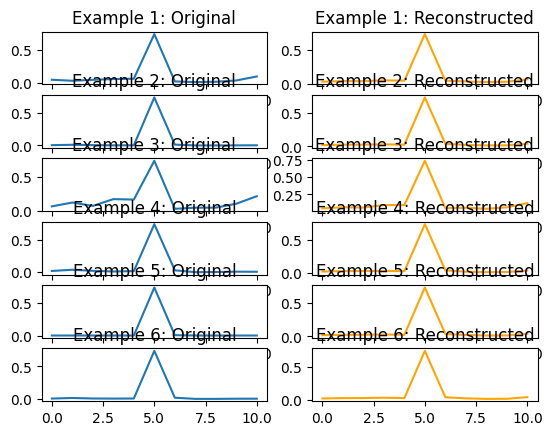

In [33]:
import matplotlib.pyplot as plt

# Predict on test data
reconstructed_data = model.predict(test_data)

# Choose a few random examples for visualization
num_examples = 6
examples_indices = np.random.choice(len(test_data), num_examples, replace=False)

# Plot original and reconstructed data
for i, example_index in enumerate(examples_indices, 1):
    plt.subplot(num_examples, 2, 2 * i - 1)
    plt.plot(test_data[example_index], label='Original')
    plt.title(f'Example {i}: Original')
    #plt.legend()

    plt.subplot(num_examples, 2, 2 * i)
    plt.plot(reconstructed_data[example_index], label='Reconstructed', color='orange')
    plt.title(f'Example {i}: Reconstructed')
    #plt.legend()

plt.show()


In [34]:
print(test_data)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.08421980e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.81684396e-06]
 ...
 [1.63948000e-02 7.96524258e-03 1.56812725e-02 ... 1.70657323e-02
  4.01098444e-02 2.05174372e-01]
 [1.97068808e-02 4.85155684e-02 2.28841537e-02 ... 6.33313867e-02
  1.17488320e-01 3.58581408e-01]
 [2.07005051e-03 1.44822592e-03 2.02581032e-03 ... 4.73687626e-03
  1.69046232e-02 9.77480219e-02]]


In [35]:
print(reconstructed_data)

[[0.01974729 0.02436778 0.02579121 ... 0.01462067 0.01565748 0.04131274]
 [0.0197476  0.02436803 0.02579148 ... 0.01462066 0.01565741 0.04131209]
 [0.01974753 0.02436798 0.02579142 ... 0.01462066 0.01565742 0.04131223]
 ...
 [0.02088529 0.02840852 0.02725866 ... 0.02527382 0.03223193 0.09868847]
 [0.02635087 0.03430898 0.03259724 ... 0.04738974 0.07145107 0.22368853]
 [0.01849469 0.02427278 0.02458946 ... 0.01756096 0.02032954 0.06022241]]
